# Introduction
### 🧾 Problem Statement
With the rapid rise in AI-generated visual content, distinguishing real-world driving scenes from synthetic ones is increasingly important for maintaining data integrity in autonomous driving systems. This notebook focuses on training a deep learning model that can accurately classify RGB images as either:

Real (label = 1)

Fake (label = 0)

___
### 📁 Dataset Overview  
Images are in JPEG format and in RGB color space.

Labels are provided for training data.

Test data is unlabeled and evaluated through a test dir.
___
### ⚙️ Objective
Preprocess the data.

Train a robust neural network model for binary classification.

Use transfer learning with pre-trained CNN architectures (Xception, EfficientNet, MobileNet, etc.) to boost performance.

Generate predictions for the test dataset and format them for submission.

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hananabhan","key":"85ae4f7846c45bb1716d0792feee15dc"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c cidaut-ai-fake-scene-classification-2024
!unzip -q cidaut-ai-fake-scene-classification-2024.zip


 83% 117M/141M [00:00<00:00, 1.22GB/s]
100% 141M/141M [00:00<00:00, 1.13GB/s]


# Imports

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import collections
import cv2
from tensorflow.keras import layers
import random

from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small ,EfficientNetB0,EfficientNetV2B0,Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


In [6]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load Data

In [7]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,image,label
0,1.jpg,editada
1,2.jpg,real
2,3.jpg,real
3,6.jpg,editada
4,8.jpg,real


In [8]:
print(train_df.columns)


Index(['image', 'label'], dtype='object')


In [9]:
train_df['label'] = train_df['label'].astype(str)


In [10]:
class_counts=train_df['label'].value_counts()
print(class_counts)


label
real       405
editada    315
Name: count, dtype: int64


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
    validation_split=0.1

)

In [38]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/Train',
    x_col='image',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    shuffle=True
)


Found 648 validated image filenames belonging to 2 classes.


In [13]:
val_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/Train',
    x_col='image',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    shuffle=False  )

Found 72 validated image filenames belonging to 2 classes.


In [14]:
test_images = []
image_names = []
test_dir="/content/Test"
for filename in sorted(os.listdir(test_dir)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(test_dir, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        test_images.append(img_array)
        image_names.append(filename)

X_test = np.array(test_images)

# Some Analysis

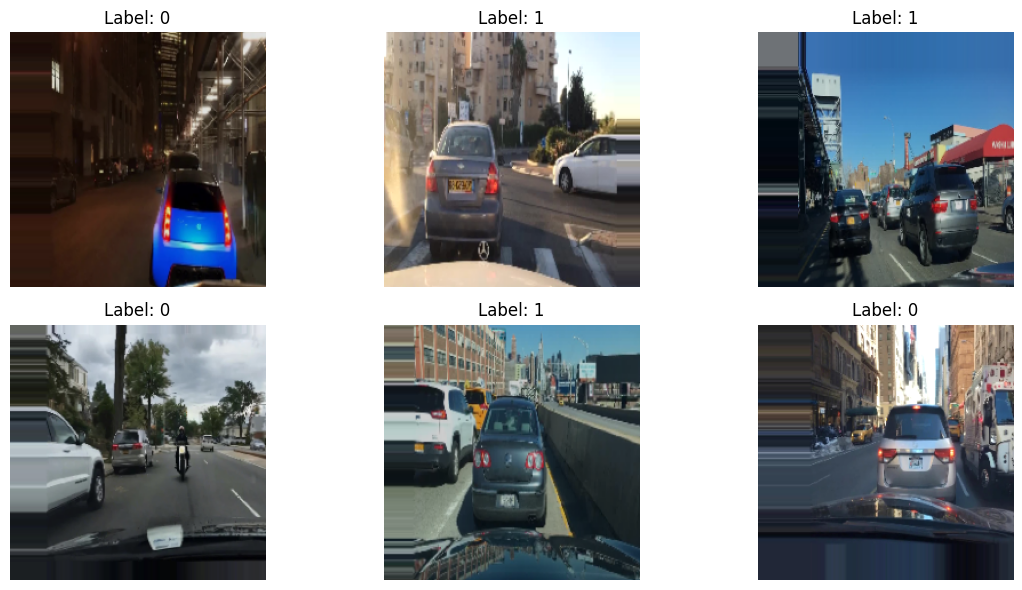

In [15]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

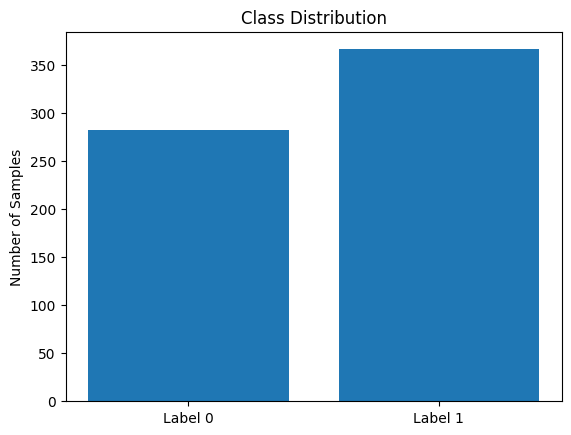

In [39]:
labels_list = []
num_batches = len(train_generator)

for _ in range(num_batches):
    _, labels = next(train_generator)
    labels_list.extend(labels)

label_counts = collections.Counter(labels_list)

plt.bar(['Label 0', 'Label 1'], [label_counts[0], label_counts[1]])
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.show()

it is slightly imbalanced

In [17]:
total = len(train_df)
percentages = (class_counts / total) * 100

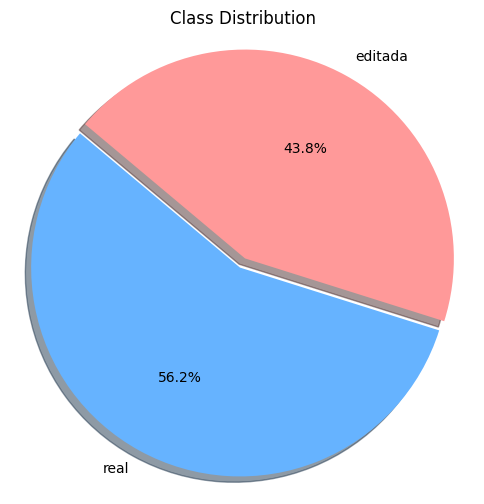

In [40]:
labels = class_counts.index
sizes = class_counts.values
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# Modeling

## mobilevnet2

MobileNet V2 is a lightweight convolutional neural network architecture designed by Google for efficient on-device computer vision 
Zhihu
+15
Google Research
+15
machinethink.net
+15
. It builds on the foundation laid by MobileNet V1 but introduces two key innovations that enhance both performance and efficiency:  
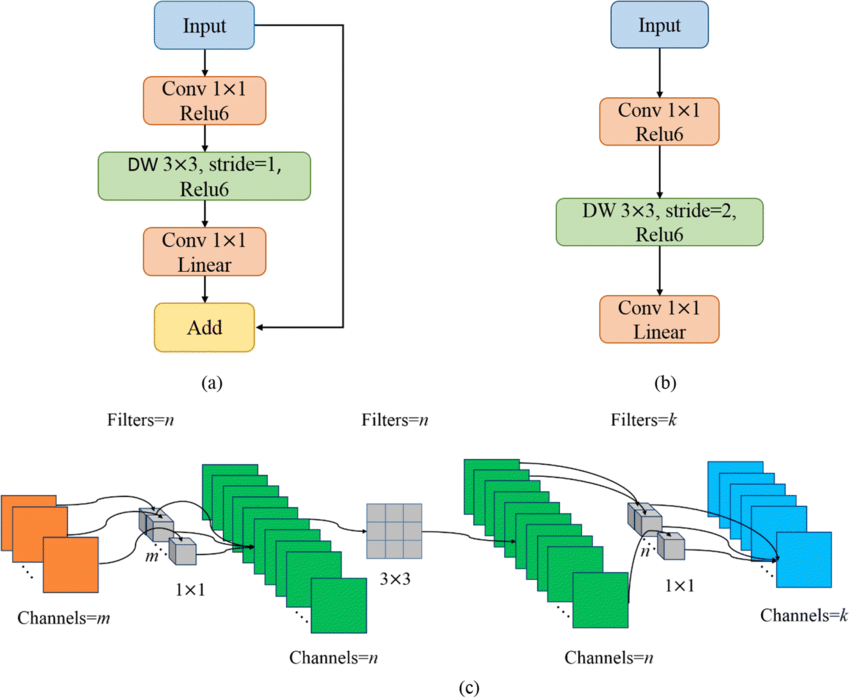

In [19]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))


In [22]:
checkpoint_cb = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [23]:
history_v2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4753 - loss: 0.8588
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4764 - loss: 0.8575 - val_accuracy: 0.5000 - val_loss: 0.7594
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4971 - loss: 0.7747
Epoch 2: val_accuracy improved from 0.50000 to 0.56944, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 700ms/step - accuracy: 0.4973 - loss: 0.7755 - val_accuracy: 0.5694 - val_loss: 0.7139
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.4951 - loss: 0.8300
Epoch 3: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 664ms/step - accuracy: 0.4950 - loss: 0.8296 - val_accuracy: 0.4722 - val_loss: 0.7369
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.4912 - loss: 0.8116
Epoch 4: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 673ms/step - accuracy: 0.4918 - loss: 0.8113 - val_accuracy: 0.4444 - val_loss: 0.7739
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.4771 - loss: 0.8513
Epoch 5: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 692ms/step - accuracy: 0.4791 - loss: 0.8485 - val_accuracy: 0.4722 - val_loss: 0.7416
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5163 - loss: 0.7717
Epoch 6: val_accuracy did not i

In [24]:
best_model = load_model('best_model.h5')

In [25]:
loss, accuracy = best_model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 926ms/step - accuracy: 0.4579 - loss: 0.7958
Validation Accuracy: 0.4861, Loss: 0.7814


In [26]:
preds = best_model.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})
submission_df.to_csv('submission_mobile.csv', index=False)


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


## mobilevnet3small


In [27]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'best_mobilenetv3_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_v3small = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.4454 - loss: 0.7359
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to best_mobilenetv3_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4453 - loss: 0.7357 - val_accuracy: 0.4583 - val_loss: 0.7303
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.4294 - loss: 0.7370
Epoch 2: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 671ms/step - accuracy: 0.4303 - loss: 0.7366 - val_accuracy: 0.4583 - val_loss: 0.7139
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.4904 - loss: 0.7071
Epoch 3: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 658ms/step - accuracy: 0.4899 - loss: 0.7072 - val_accuracy: 0.4583 - val_loss: 0.7046
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.4968 - loss: 0.7001
Epoch 4: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.4976 - loss: 0.6999 - val_accuracy: 0.4583 - val_loss: 0.6997
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.4743 - loss: 0.7106
Epoch 5: val_accuracy did not impr

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 663ms/step - accuracy: 0.4901 - loss: 0.7026 - val_accuracy: 0.5694 - val_loss: 0.6928
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5055 - loss: 0.7051
Epoch 9: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 655ms/step - accuracy: 0.5044 - loss: 0.7051 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.5141 - loss: 0.7034
Epoch 10: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 655ms/step - accuracy: 0.5142 - loss: 0.7031 - val_accuracy: 0.4444 - val_loss: 0.6937
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.4910 - loss: 0.7137
Epoch 11: val_accuracy improved from 0.56944 to 0.58333, saving model to best_mobilenetv3_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 667ms/step - accuracy: 0.4913 - loss: 0.7135 - val_accuracy: 0.5833 - val_loss: 0.6917
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.4651 - loss: 0.7071
Epoch 12: val_accuracy did not improve from 0.58333
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 649ms/step - accuracy: 0.4675 - loss: 0.7068 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 13/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4926 - loss: 0.7076
Epoch 13: val_accuracy did not improve from 0.58333
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 644ms/step - accuracy: 0.4926 - loss: 0.7077 - val_accuracy: 0.5833 - val_loss: 0.6928
Epoch 14/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.4653 - loss: 0.7087
Epoch 14: val_accuracy did not improve from 0.58333
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 648ms/step - accuracy: 0.4657 - loss: 0.7088 - val_accuracy: 0.5417 - val_loss: 0.6927
Epoch 15/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.4703 - loss: 0.7010
Epoch 15: val_accuracy d

## effiecntnetb0

In [28]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x= layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x= layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'effcientb0_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return (lr * tf.math.exp(-0.1)).numpy()

history_efficent = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb, tf.keras.callbacks.LearningRateScheduler(scheduler)],
    class_weight=class_weight_dict
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5284 - loss: 2.7744
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to effcientb0_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5267 - loss: 2.7518 - val_accuracy: 0.4583 - val_loss: 1.9780 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5220 - loss: 1.8091
Epoch 2: val_accuracy improved from 0.45833 to 0.54167, saving model to effcientb0_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 682ms/step - accuracy: 0.5218 - loss: 1.8029 - val_accuracy: 0.5417 - val_loss: 1.3731 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.4766 - loss: 1.3079
Epoch 3: val_accuracy did not improve from 0.54167
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 656ms/step - accuracy: 0.4760 - loss: 1.3043 - val_accuracy: 0.5417 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5129 - loss: 1.0449
Epoch 4: val_accuracy did not improve from 0.54167
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 691ms/step - accuracy: 0.5123 - loss: 1.0430 - val_accuracy: 0.4583 - val_loss: 0.9325 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5403 - loss: 0.9090
Epoch 5: val_accuracy did not improve from 0.54167
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 663ms/step - accuracy: 0.5391 - loss: 0.9085 - val_accuracy: 0.4583 - val_loss: 0.8779 - learning_rate: 0.0010
Epoch 6/15
21/21 ━━━━

In [29]:
effcientb0_model = load_model('effcientb0_model.h5')
loss, accuracy = effcientb0_model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5404 - loss: 1.3735
Validation Accuracy: 0.5417, Loss: 1.3731


In [30]:
preds = effcientb0_model.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})
submission_df.to_csv('submission_effic.csv', index=False)


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


## efficentv2

In [31]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x= layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'effcientv2b0_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='min',
    verbose=1
)
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return (lr * tf.math.exp(-0.1)).numpy()

history_efficentv2b0 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb, tf.keras.callbacks.LearningRateScheduler(scheduler)],
    class_weight=class_weight_dict
)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4822 - loss: 0.7067
Epoch 1: val_accuracy improved from inf to 0.45833, saving model to effcientv2b0_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4827 - loss: 0.7067 - val_accuracy: 0.4583 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5041 - loss: 0.7016
Epoch 2: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 658ms/step - accuracy: 0.5046 - loss: 0.7018 - val_accuracy: 0.4583 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4635 - loss: 0.7134
Epoch 3: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - accuracy: 0.4648 - loss: 0.7132 - val_accuracy: 0.5417 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5012 - loss: 0.6986
Epoch 4: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 669ms/step - accuracy: 0.5018 - loss: 0.6986 - val_accuracy: 0.4583 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━

In [32]:
effcientv2b0_model = load_model('effcientv2b0_model.h5')
loss, accuracy = effcientv2b0_model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4596 - loss: 0.6945
Validation Accuracy: 0.4583, Loss: 0.6946


## xception


In [53]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'xceptionl.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
history_xception = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5521 - loss: 11.1434
Epoch 1: val_loss improved from inf to 4.27806, saving model to xceptionl.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.5506 - loss: 11.0146 - val_accuracy: 0.4583 - val_loss: 4.2781
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.6486 - loss: 2.6074
Epoch 2: val_loss did not improve from 4.27806
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 809ms/step - accuracy: 0.6496 - loss: 2.5763 - val_accuracy: 0.4583 - val_loss: 26.2298
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7097 - loss: 0.7638
Epoch 3: val_loss did not improve from 4.27806
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 798ms/step - accuracy: 0.7106 - loss: 0.7606 - val_accuracy: 0.6528 - val_loss: 7.4552
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7545 - loss: 0.5533
Epoch 4: val_loss did not improve from 4.27806
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 842ms/step - accuracy: 0.7548 - loss: 0.5525 - val_accuracy: 0.4583 - val_loss: 17.3716
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8168 - loss: 0.4522
Epoch 5: val_loss did not improve from 4.27

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9046 - loss: 0.3347 - val_accuracy: 0.7222 - val_loss: 3.1724
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8743 - loss: 0.3205
Epoch 8: val_loss improved from 3.17240 to 0.48512, saving model to xceptionl.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8747 - loss: 0.3200 - val_accuracy: 0.8194 - val_loss: 0.4851
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.9081 - loss: 0.2930
Epoch 9: val_loss did not improve from 0.48512
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 855ms/step - accuracy: 0.9081 - loss: 0.2931 - val_accuracy: 0.8333 - val_loss: 1.0239
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.9220 - loss: 0.2376
Epoch 10: val_loss did not improve from 0.48512
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 796ms/step - accuracy: 0.9211 - loss: 0.2390 - val_accuracy: 0.5833 - val_loss: 1.8053
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9394 - loss: 0.1924
Epoch 11: val_loss did not improve from 0.48512
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 791ms/step - accuracy: 0.9387 - loss: 0.1936 - val_accuracy: 0.8472 - val_loss: 0.7983
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.9379 - loss: 0.1932
Epoch 12: val_loss did not improve from 0

In [54]:
xceptionl = load_model('xceptionl.h5')
loss, accuracy = xceptionl.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 847ms/step - accuracy: 0.7405 - loss: 1.0283
Validation Accuracy: 0.7778, Loss: 0.8911


In [35]:
preds = model.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})
submission_df.to_csv('submission_xc.csv', index=False)


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [36]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = layers.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'xceptionl2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
history_xception2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 2.1141
Epoch 1: val_loss improved from inf to 0.69924, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4542 - loss: 2.0738 - val_accuracy: 0.4583 - val_loss: 0.6992
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.4391 - loss: 0.6940
Epoch 2: val_loss improved from 0.69924 to 0.69486, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4390 - loss: 0.6939 - val_accuracy: 0.4583 - val_loss: 0.6949
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.4321 - loss: 0.6932
Epoch 3: val_loss improved from 0.69486 to 0.69473, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.4322 - loss: 0.6933 - val_accuracy: 0.4583 - val_loss: 0.6947
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.4395 - loss: 0.6938
Epoch 4: val_loss improved from 0.69473 to 0.69429, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.4393 - loss: 0.6938 - val_accuracy: 0.4583 - val_loss: 0.6943
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.4240 - loss: 0.6916
Epoch 5: val_loss improved from 0.69429 to 0.69362, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.4246 - loss: 0.6917 - val_accuracy: 0.4583 - val_loss: 0.6936
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.4192 - loss: 0.6905
Epoch 6: val_loss improved from 0.69362 to 0.69345, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.4195 - loss: 0.6906 - val_accuracy: 0.4583 - val_loss: 0.6935
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.4638 - loss: 0.6986
Epoch 7: val_loss did not improve from 0.69345
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 817ms/step - accuracy: 0.4625 - loss: 0.6984 - val_accuracy: 0.4583 - val_loss: 0.6940
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.4311 - loss: 0.6921
Epoch 8: val_loss did not improve from 0.69345
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 787ms/step - accuracy: 0.4316 - loss: 0.6922 - val_accuracy: 0.4583 - val_loss: 0.6935
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.4405 - loss: 0.6943
Epoch 9: val_loss improved from 0.69345 to 0.69323, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4404 - loss: 0.6943 - val_accuracy: 0.4583 - val_loss: 0.6932
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.4903 - loss: 0.6941
Epoch 10: val_loss improved from 0.69323 to 0.69305, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4907 - loss: 0.6940 - val_accuracy: 0.5417 - val_loss: 0.6931
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.5234 - loss: 0.6956
Epoch 11: val_loss did not improve from 0.69305
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 784ms/step - accuracy: 0.5209 - loss: 0.6955 - val_accuracy: 0.4583 - val_loss: 0.6935
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.4418 - loss: 0.7014
Epoch 12: val_loss improved from 0.69305 to 0.69258, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.4413 - loss: 0.7019 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 13/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.4301 - loss: 0.7081
Epoch 13: val_loss did not improve from 0.69258
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 785ms/step - accuracy: 0.4312 - loss: 0.7081 - val_accuracy: 0.4583 - val_loss: 1.2891
Epoch 14/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.4569 - loss: 0.7032
Epoch 14: val_loss did not improve from 0.69258
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 810ms/step - accuracy: 0.4569 - loss: 0.7035 - val_accuracy: 0.4583 - val_loss: 1.8595
Epoch 15/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.4582 - loss: 0.6986
Epoch 15: val_loss did not improve from 0.69258
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 787ms/step - accuracy: 0.4576 - loss: 0.6987 - val_accuracy: 0.4583 - val_loss: 1.0031


In [37]:
xceptionl2 = load_model('xceptionl2.h5')
loss, accuracy = xceptionl2.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 736ms/step - accuracy: 0.4510 - loss: 0.6878
Validation Accuracy: 0.4722, Loss: 0.6847


# Results

In [49]:
def plot_model_histories(histories, model_names):
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} - Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} - Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} - Train')
        plt.plot(history.history['val_loss'], label=f'{name} - Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


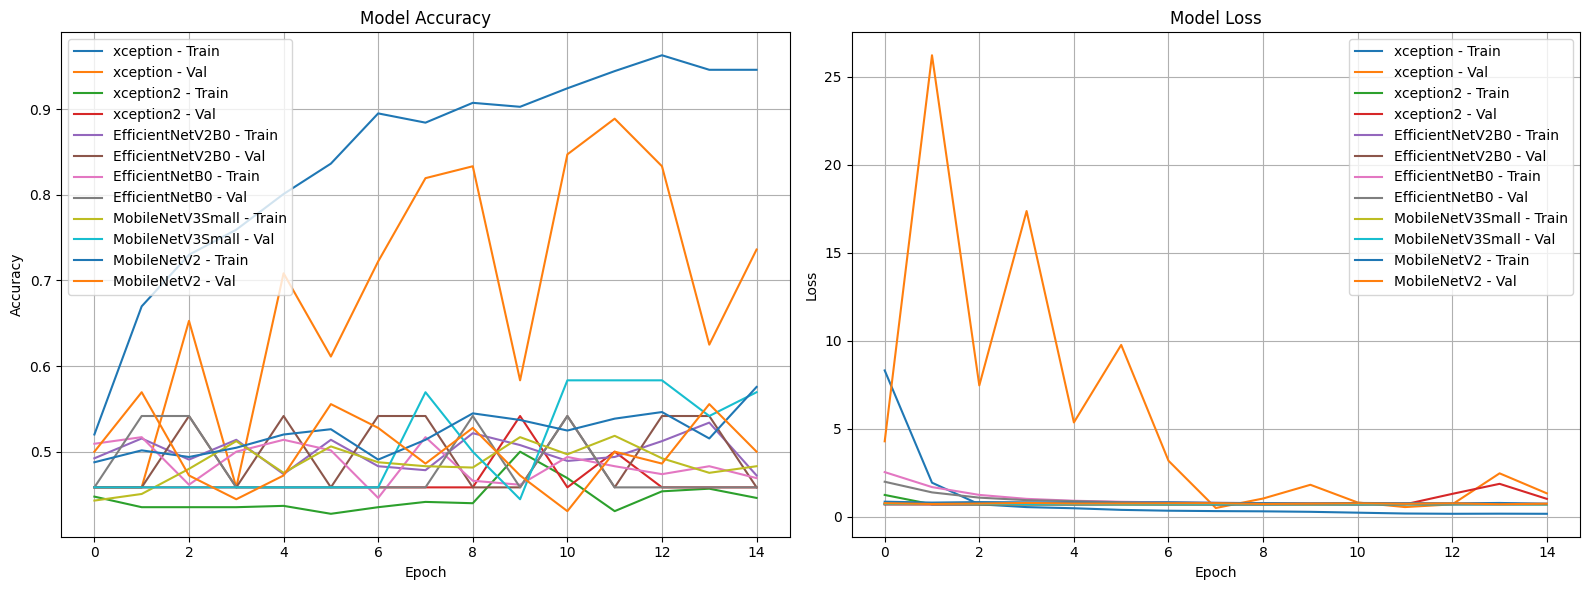

In [55]:
plot_model_histories(
    histories=[history_xception, history_xception2,history_efficentv2b0,history_efficent,history_v3small,history_v2],
    model_names=['xception', 'xception2','EfficientNetV2B0','EfficientNetB0','MobileNetV3Small','MobileNetV2']
)


In [58]:
preds = xceptionl.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 790ms/step


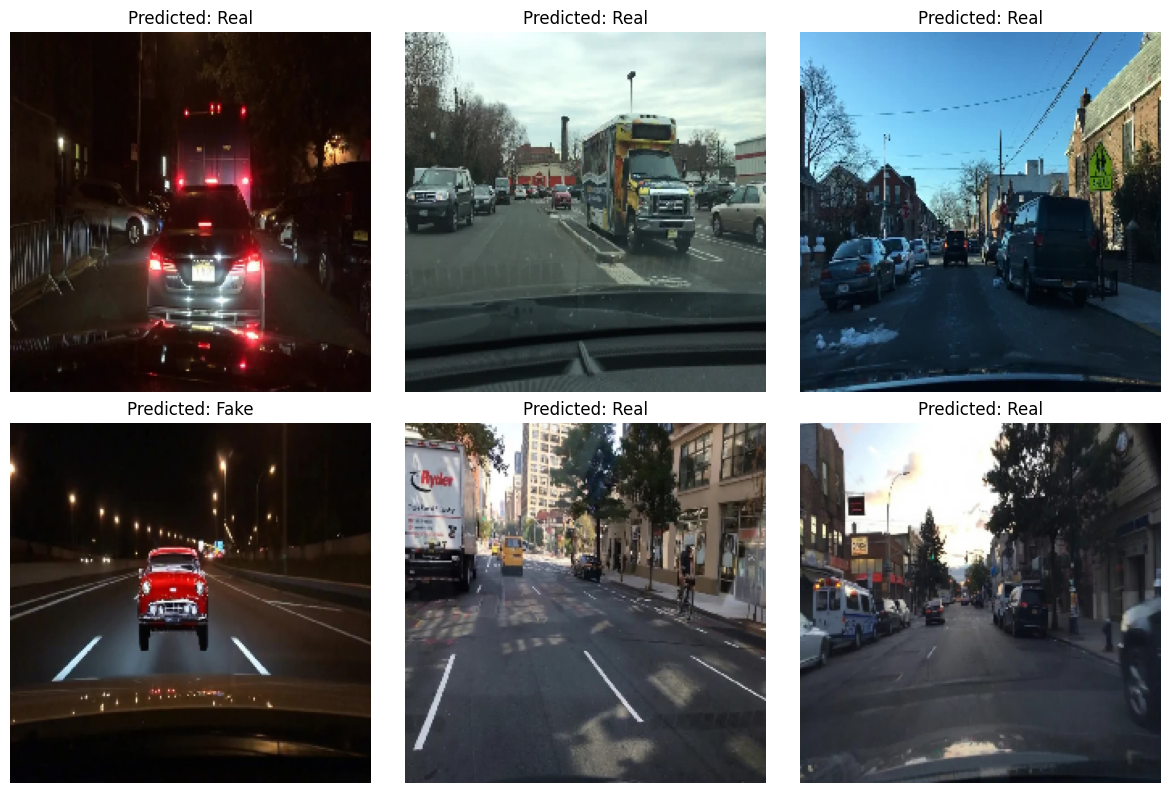

In [59]:
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {'Real' if predicted_labels[i] == 1 else 'Fake'}")
    plt.axis('off')
plt.tight_layout()
plt.show()